### **Import Libraries**

In [47]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression


#### **Load Data & Basic Info**

##### **Wrangle Function**

In [48]:
def wrangle(path, centroids):
    # Load CSV inside the function
    df = pd.read_csv(path)
    df = df.copy()

    # Remove rows with missing Retail
    df = df[df["Retail"].notna()]
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['WeekofYear'] = df['Date'].dt.isocalendar().week

    # Fill missing values
    df["SupplyVolume"] = df["SupplyVolume"].fillna(df["SupplyVolume"].median())
    df["Wholesale"] = df["Wholesale"].fillna(df["Wholesale"].median())

    # Convert Date to datetime + set index
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")

    # Create 1-hour lag for Retail
    df["Retail_lag1"] = df["Retail"].shift(1)
    df = df.dropna()

    # --- Add latitude and longitude from centroids ---
    county_name_map = {
        "Homa-Bay": "Homa Bay",
        "Muranga": "Murang'a",
        "Tana-River": "Tana River",
        "Trans-Nzoia": "Trans Nzoia",
        "West-Pokot": "West Pokot"
    }
    df['County'] = df['County'].replace(county_name_map)

    df = df.merge(
        centroids[['county_norm', 'latitude', 'longitude']],
        left_on='County',
        right_on='county_norm',
        how='left'
    )
    df = df.drop(columns=['county_norm'])

    return df


#### **Wrangle function for Transformation and Encoding s**

In [49]:
def wrangle2(df):
    # Work on a copy to avoid modifying original df
    df = df.copy()
    
    # --- Log transformations ---
    df['Wholesale_log'] = np.log1p(df['Wholesale'])
    df['Retail_log'] = np.log1p(df['Retail'])
    df['Retail_lag1_log'] = np.log1p(df['Retail_lag1'])  # <-- corrected
    df['volumesale_log'] = np.log1p(df["SupplyVolume"])
    
    # --- Rank Transformation ---
    df['Wholesale_rank'] = df['Wholesale'].rank(method='average')
    df['Retail_rank'] = df['Retail'].rank(method='average')
    df['Volume_rank'] = df['SupplyVolume'].rank(method='average')
    df['Retail_lag1_rank'] = df['Retail_lag1'].rank(method='average')  # <-- corrected

    # --- Min–Max Scaling (0 to 1 range) ---
    scaler = MinMaxScaler()
    df[['Wholesale_mm', 'Retail_mm', 'Volume_mm','Retail_lag1_rank_mm']] = scaler.fit_transform(
        df[['Wholesale', 'Retail', 'SupplyVolume','Retail_lag1']]
    )

    return df


In [50]:
# Kenyan county centroid coordinates (approximate)
# Source: Public GIS datasets / government county shapefiles (preloaded here manually)
data = {
    "county_norm": [
        "Baringo", "Bomet", "Bungoma", "Busia", "Elgeyo-Marakwet", "Embu",
        "Garissa", "Homa Bay", "Isiolo", "Kajiado", "Kakamega", "Kericho",
        "Kiambu", "Kilifi", "Kirinyaga", "Kisii", "Kisumu", "Kitui",
        "Kwale", "Laikipia", "Lamu", "Machakos", "Makueni", "Mandera",
        "Marsabit", "Meru", "Migori", "Mombasa", "Murang'a", "Nairobi",
        "Nakuru", "Nandi", "Narok", "Nyamira", "Nyandarua", "Nyeri",
        "Samburu", "Siaya", "Taita-Taveta", "Tana River", "Tharaka-Nithi",
        "Trans Nzoia", "Turkana", "Uasin-Gishu", "Vihiga", "Wajir", "West Pokot"
    ],
    "latitude": [
        0.469, -0.801, 0.569, 0.434, 1.046, -0.531,
        -0.453, -0.495, 0.352, -2.098, 0.307, -0.377,
        -1.030, -3.510, -0.498, -0.681, -0.091, -1.366,
        -4.175, 0.421, -2.162, -1.517, -2.247, 3.937,
        3.544, 0.355, -1.064, -4.043, -0.783, -1.286,
        -0.303, 0.205, -1.145, -0.566, -0.258, -0.419,
        0.993, -0.133, -3.316, -1.845, -0.283, 1.010,
        3.118, 0.539, 0.023, 1.748, 1.532
    ],
    "longitude": [
        35.990, 35.342, 34.564, 34.124, 35.363, 37.456,
        39.654, 34.639, 38.570, 36.789, 34.751, 35.279,
        36.868, 39.800, 37.318, 34.778, 34.761, 38.015,
        39.458, 36.787, 40.902, 37.263, 37.892, 41.847,
        37.998, 37.655, 34.473, 39.668, 36.605, 36.816,
        36.188, 35.117, 35.860, 34.935, 36.574, 36.947,
        37.537, 34.266, 37.757, 39.507, 37.908, 35.021,
        35.587, 35.283, 34.729, 40.060, 35.162
    ]
}

centroids = pd.DataFrame(data)
centroids.head()

,county_norm,latitude,longitude
0,Baringo,0.469,35.990
1,Bomet,-0.801,35.342
2,Bungoma,0.569,34.564
3,Busia,0.434,34.124
4,Elgeyo-Marakwet,1.046,35.363


In [51]:
# Load CSV
df = wrangle(r"C:\Users\Admin\DSA3020-VA-Capstone-Project\DATA\raw\kamis_maize_prices.csv",centroids)

# Basic overview
print(df.head())



      Commodity_Classification  Commodity     Classification   County  \
0              Dry_White_Maize  Dry_Maize        White_Maize  Baringo   
1              Dry_White_Maize  Dry_Maize        White_Maize  Baringo   
2              Dry_White_Maize  Dry_Maize        White_Maize  Baringo   
3              Dry_White_Maize  Dry_Maize        White_Maize  Baringo   
4  Dry_Maize_Mixed_Traditional  Dry_Maize  Mixed_Traditional  Baringo   

                 Market  Year  Month Year_Month  WeekofYear Year_Week  \
0       Kabarnet_Market  2021      5    2021-05          21   2021-21   
1       Kabarnet_Market  2021      5    2021-05          21   2021-21   
2        Marigat_Market  2021      5    2021-05          21   2021-21   
3        Marigat_Market  2021      5    2021-05          21   2021-21   
4  Eldama_Ravine_Market  2021      5    2021-05          21   2021-21   

   SupplyVolume  Retail  Wholesale Unit  Retail_lag1  latitude  longitude  
0        2000.0    40.0      22.22   Kg       

In [52]:
# Second wrangle: log transforms + quantiles
df2 = wrangle2(df)

print(df2.head())


      Commodity_Classification  Commodity     Classification   County  \
0              Dry_White_Maize  Dry_Maize        White_Maize  Baringo   
1              Dry_White_Maize  Dry_Maize        White_Maize  Baringo   
2              Dry_White_Maize  Dry_Maize        White_Maize  Baringo   
3              Dry_White_Maize  Dry_Maize        White_Maize  Baringo   
4  Dry_Maize_Mixed_Traditional  Dry_Maize  Mixed_Traditional  Baringo   

                 Market  Year  Month Year_Month  WeekofYear Year_Week  ...  \
0       Kabarnet_Market  2021      5    2021-05          21   2021-21  ...   
1       Kabarnet_Market  2021      5    2021-05          21   2021-21  ...   
2        Marigat_Market  2021      5    2021-05          21   2021-21  ...   
3        Marigat_Market  2021      5    2021-05          21   2021-21  ...   
4  Eldama_Ravine_Market  2021      5    2021-05          21   2021-21  ...   

   Retail_lag1_log  volumesale_log  Wholesale_rank Retail_rank  Volume_rank  \
0         3.4

#### **Data information and description**

In [53]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21015 entries, 0 to 21014
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Commodity_Classification  21015 non-null  object 
 1   Commodity                 21015 non-null  object 
 2   Classification            21015 non-null  object 
 3   County                    21015 non-null  object 
 4   Market                    21015 non-null  object 
 5   Year                      21015 non-null  int32  
 6   Month                     21015 non-null  int32  
 7   Year_Month                21015 non-null  object 
 8   WeekofYear                21015 non-null  UInt32 
 9   Year_Week                 21015 non-null  object 
 10  SupplyVolume              21015 non-null  float64
 11  Retail                    21015 non-null  float64
 12  Wholesale                 21015 non-null  float64
 13  Unit                      21015 non-null  object 
 14  Retail

#### **EDA**

In [54]:
print(df.describe())

               Year         Month  WeekofYear  SupplyVolume        Retail  \
count  21015.000000  21015.000000     21015.0  2.101500e+04  21015.000000   
mean    2022.335522      6.558696   26.721532  2.274007e+04     62.198928   
std        1.089400      3.116571   13.445062  9.893827e+05     73.861379   
min     2021.000000      1.000000         1.0  0.000000e+00      6.390000   
25%     2021.000000      5.000000        18.0  2.070000e+03     40.000000   
50%     2022.000000      7.000000        26.0  4.800000e+03     60.000000   
75%     2023.000000      9.000000        38.0  9.000000e+03     75.000000   
max     2025.000000     12.000000        52.0  1.000000e+08   5500.000000   

          Wholesale   Retail_lag1      latitude     longitude  
count  21015.000000  21015.000000  21015.000000  21015.000000  
mean      50.551970     62.197501     -0.398902     36.197896  
std       30.148096     73.861711      1.221032      1.661465  
min        0.020000      6.390000     -4.175000   

- ##### **Handling Missing Values**

In [55]:
for col in df.columns:
    missing_pct = (df[col].isnull().sum() / df.shape[0]) * 100
    print(f"{col}: {missing_pct:.2f}% missing")



Commodity_Classification: 0.00% missing
Commodity: 0.00% missing
Classification: 0.00% missing
County: 0.00% missing
Market: 0.00% missing
Year: 0.00% missing
Month: 0.00% missing
Year_Month: 0.00% missing
WeekofYear: 0.00% missing
Year_Week: 0.00% missing
SupplyVolume: 0.00% missing
Retail: 0.00% missing
Wholesale: 0.00% missing
Unit: 0.00% missing
Retail_lag1: 0.00% missing
latitude: 0.00% missing
longitude: 0.00% missing


#### **Histograms**

<Axes: title={'center': 'Distribution of Retial'}>

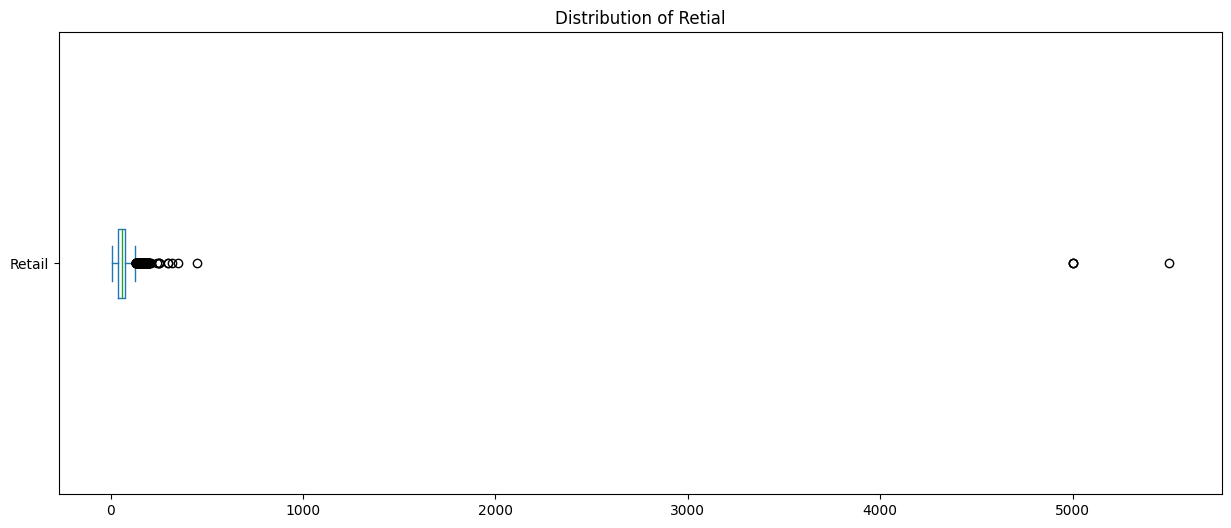

In [56]:
fig, ax=plt.subplots(figsize=(15,6))
df["Retail"].plot(kind="box",vert=False, title="Distribution of Retial",ax=ax)

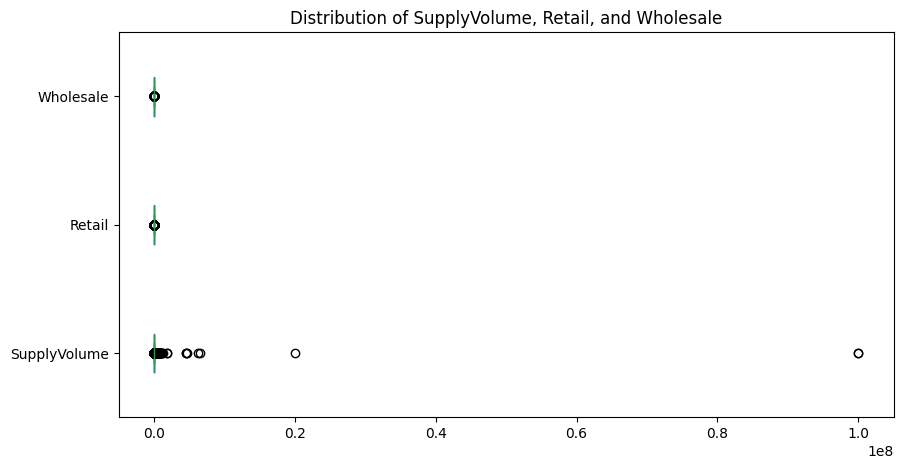

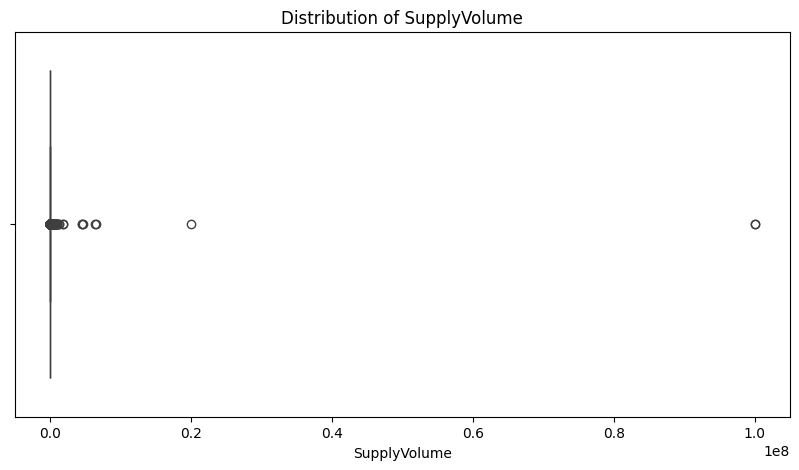

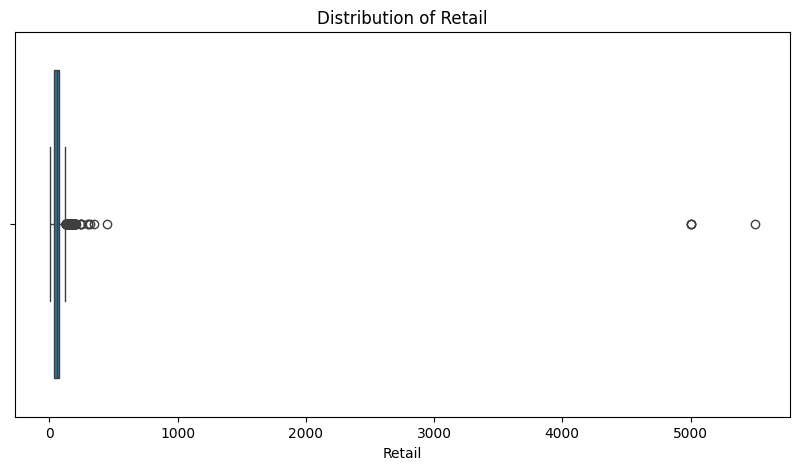

In [57]:
# --- Combined horizontal boxplot for multiple columns ---
df[['SupplyVolume', 'Retail', 'Wholesale']].plot.box(
    vert=False,
    figsize=(10,5),
    title="Distribution of SupplyVolume, Retail, and Wholesale"
)
plt.show()

# --- Single boxplot for SupplyVolume to check outliers ---
plt.figure(figsize=(10,5))
plt.title("Distribution of SupplyVolume")
sns.boxplot(x='SupplyVolume', data=df)
plt.show()

# --- Single boxplot for Retail to check outliers ---
plt.figure(figsize=(10,5))
plt.title("Distribution of Retail")
sns.boxplot(x='Retail', data=df)
plt.show()


In [58]:
import folium

# --- Step 1: Compute average Retail per County ---
avg_retail = df.groupby('County')['Retail'].mean().reset_index()

# Merge with centroids to get coordinates
map_data = avg_retail.merge(
    centroids[['county_norm', 'latitude', 'longitude']],
    left_on='County',
    right_on='county_norm',
    how='left'
)

# --- Step 2: Create base map centered in Kenya ---
kenya_map = folium.Map(location=[0.0236, 37.9062], zoom_start=6)  # Kenya approx center

# --- Step 3: Add circle markers for each county ---
for _, row in map_data.iterrows():
    # Skip counties with missing coordinates
    if pd.isna(row['latitude']) or pd.isna(row['longitude']):
        continue

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        color='blue',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7,
        popup=f"{row['County']}: KES {row['Retail']:.2f}"
    ).add_to(kenya_map)

kenya_map.save("kenya_retail_map.html")



Index(['Commodity_Classification', 'Commodity', 'Classification', 'County',
       'Market', 'Year', 'Month', 'Year_Month', 'WeekofYear', 'Year_Week',
       'SupplyVolume', 'Retail', 'Wholesale', 'Unit', 'Retail_lag1',
       'latitude', 'longitude'],
      dtype='object')

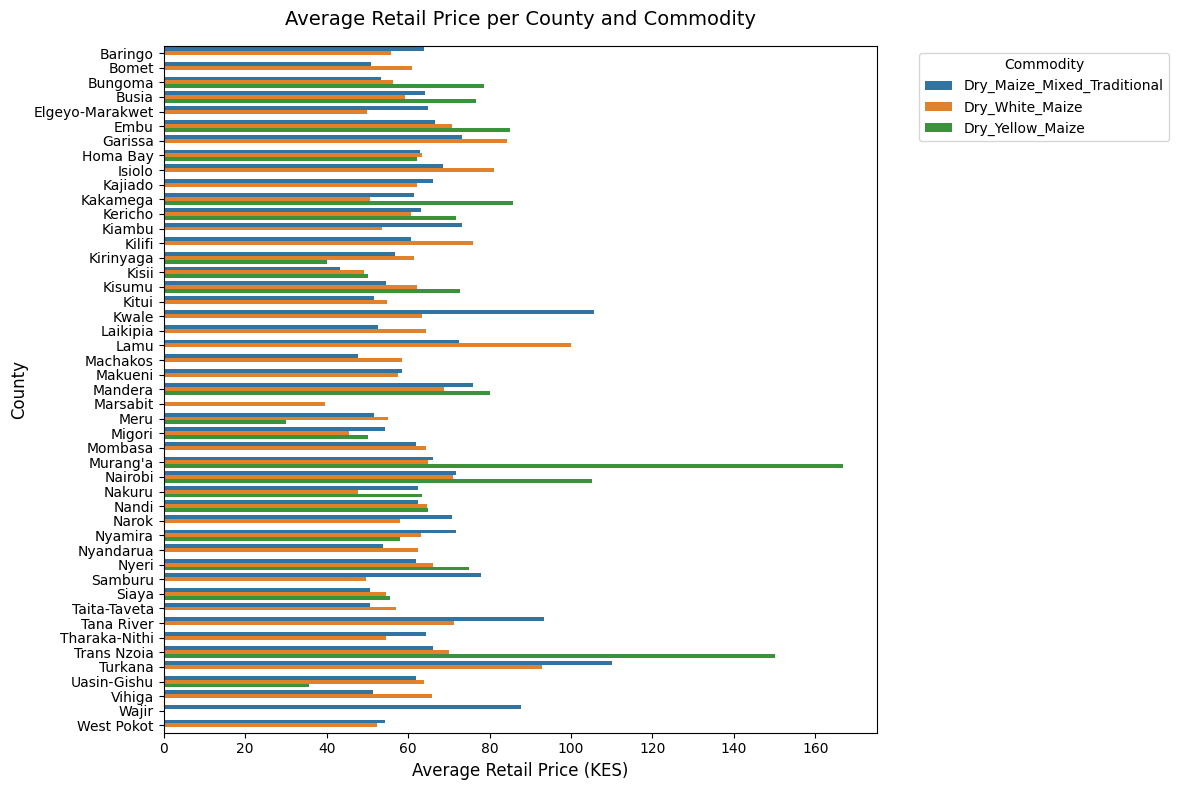

In [59]:
# Clean column names
df.columns = df.columns.str.strip()

# --- Step 1: Aggregate average Retail price per County and Commodity ---
agg_retail = df.groupby(['County', 'Commodity_Classification'])['Retail'].mean().reset_index()

# --- Step 2: Horizontal bar plot ---
plt.figure(figsize=(12, 8))
sns.barplot(
    data=agg_retail,
    y='County',        # horizontal bars
    x='Retail',        # bar length
    hue='Commodity_Classification',   # different commodities as colors
    dodge=True          # separate bars per Commodity
)

plt.title("Average Retail Price per County and Commodity", fontsize=14, pad=15)
plt.xlabel("Average Retail Price (KES)", fontsize=12)
plt.ylabel("County", fontsize=12)
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


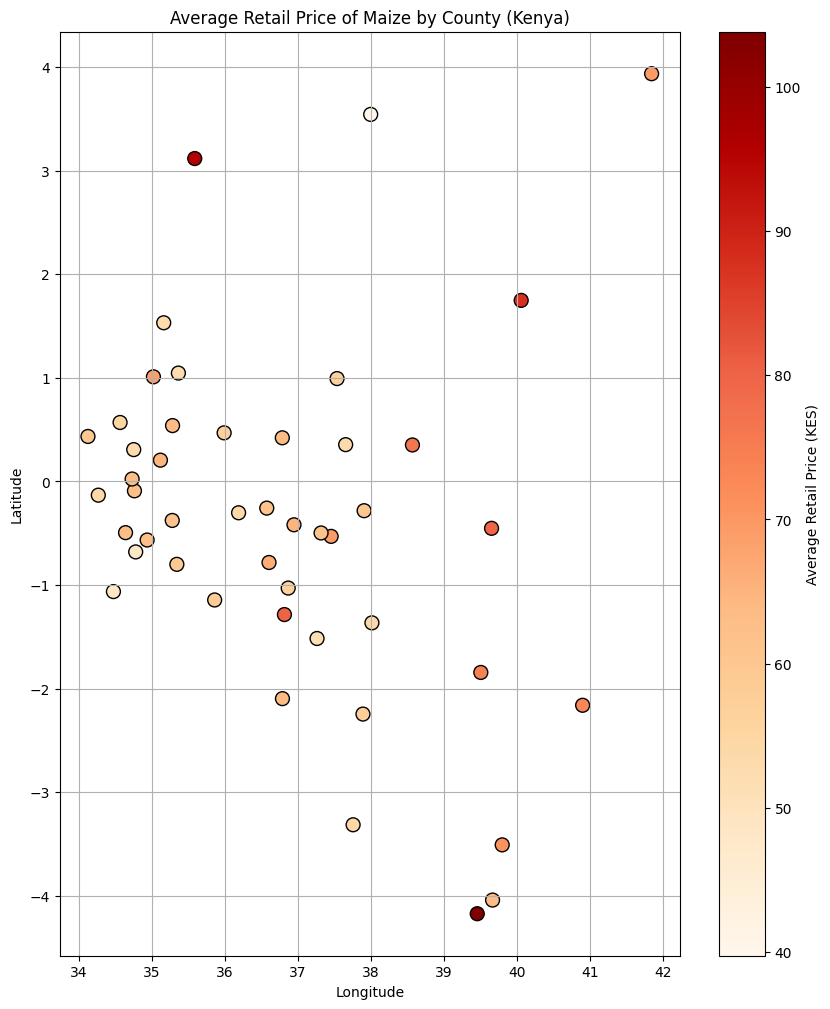

In [60]:
import matplotlib.pyplot as plt

# Merge average Retail with centroids
avg_retail = df.groupby('County')['Retail'].mean().reset_index()
map_data = avg_retail.merge(
    centroids[['county_norm', 'latitude', 'longitude']],
    left_on='County',
    right_on='county_norm',
    how='left'
)

# Drop missing coordinates
map_data = map_data.dropna(subset=['latitude', 'longitude'])

# Create scatter plot
plt.figure(figsize=(10, 12))
sc = plt.scatter(
    x=map_data['longitude'],
    y=map_data['latitude'],
    c=map_data['Retail'],       # Color by Retail price
    s=100,                      # Marker size
    cmap='OrRd',                # Color map
    edgecolor='k'
)
plt.colorbar(sc, label='Average Retail Price (KES)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average Retail Price of Maize by County (Kenya)')
plt.grid(True)
plt.show()


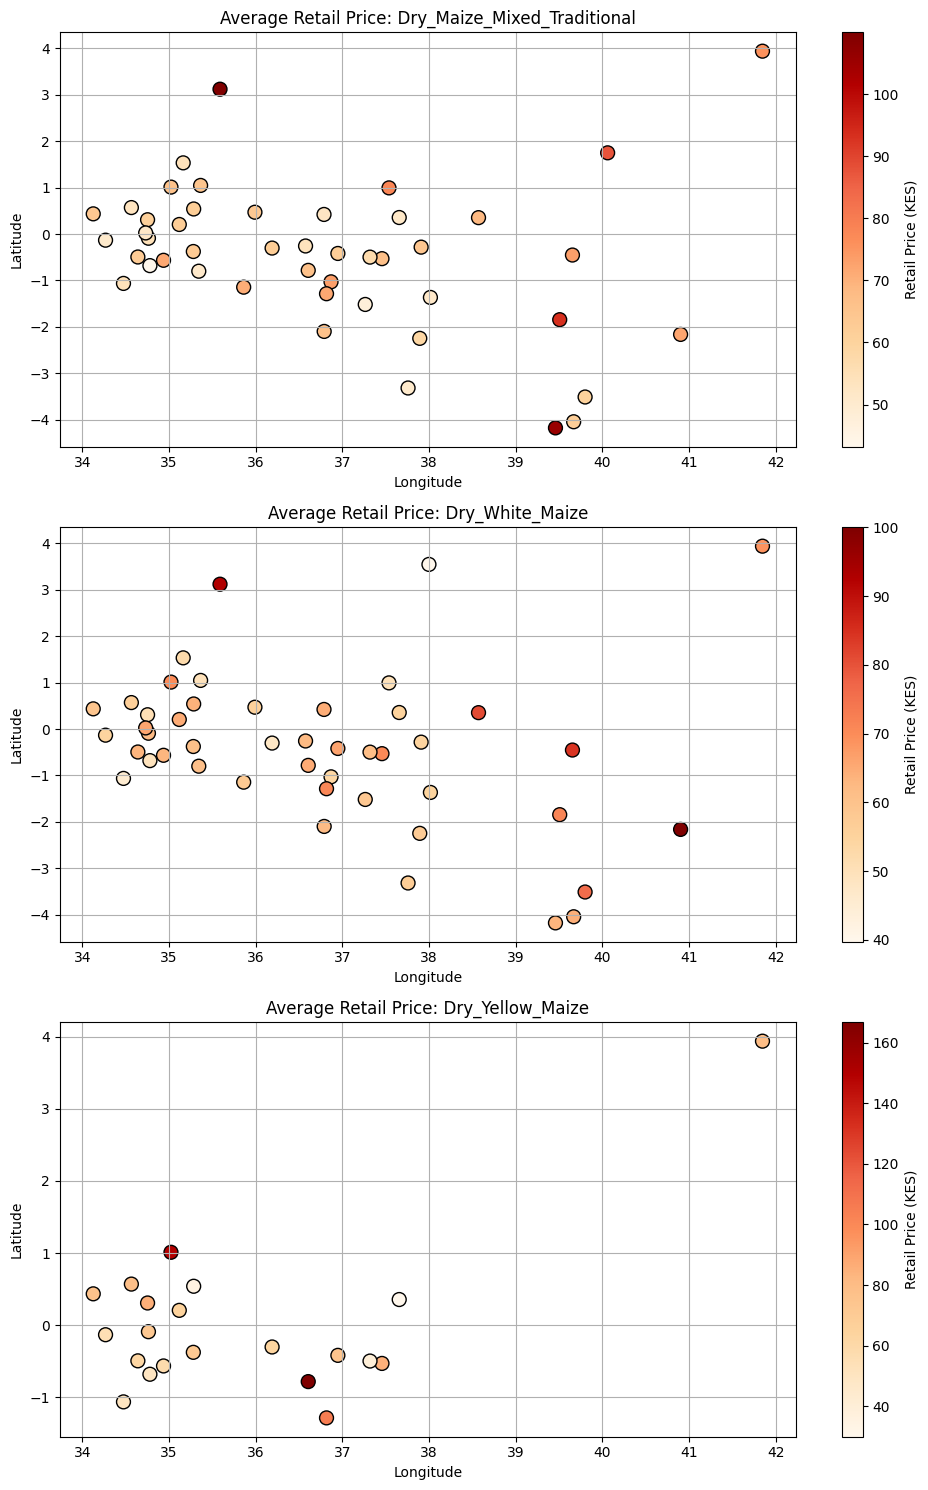

In [74]:
import matplotlib.pyplot as plt

# Aggregate by County and Commodity_Classification
agg_retail = df.groupby(['County', 'Commodity_Classification'])['Retail'].mean().reset_index()

# Merge with centroids
agg_map_data = agg_retail.merge(
    centroids[['county_norm', 'latitude', 'longitude']],
    left_on='County',
    right_on='county_norm',
    how='left'
)
agg_map_data = agg_map_data.dropna(subset=['latitude', 'longitude'])

# Get unique maize types
maize_types = agg_map_data['Commodity_Classification'].unique()

# Create subplots
fig, axes = plt.subplots(len(maize_types), 1, figsize=(10, 5*len(maize_types)))

for i, maize in enumerate(maize_types):
    data = agg_map_data[agg_map_data['Commodity_Classification'] == maize]
    sc = axes[i].scatter(
        x=data['longitude'],
        y=data['latitude'],
        c=data['Retail'],
        s=100,
        cmap='OrRd',
        edgecolor='k'
    )
    axes[i].set_title(f'Average Retail Price: {maize}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    axes[i].grid(True)
    plt.colorbar(sc, ax=axes[i], label='Retail Price (KES)')

plt.tight_layout()
plt.show()


##### **Data Balance**

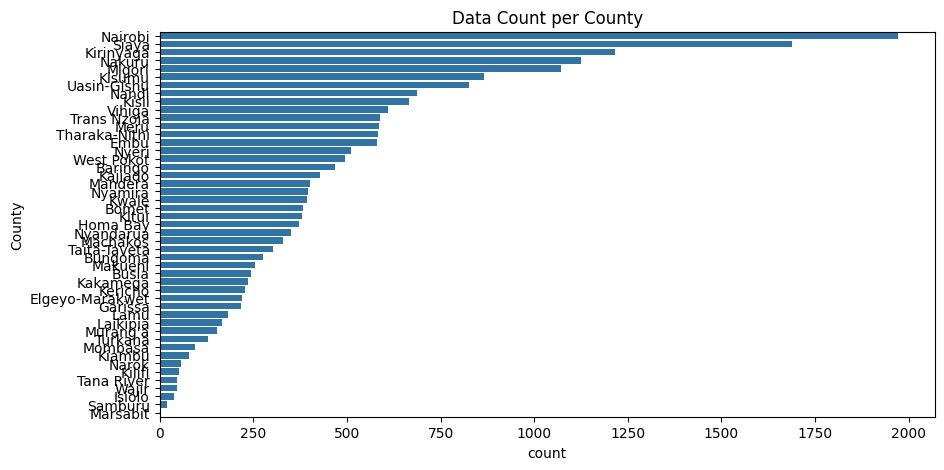

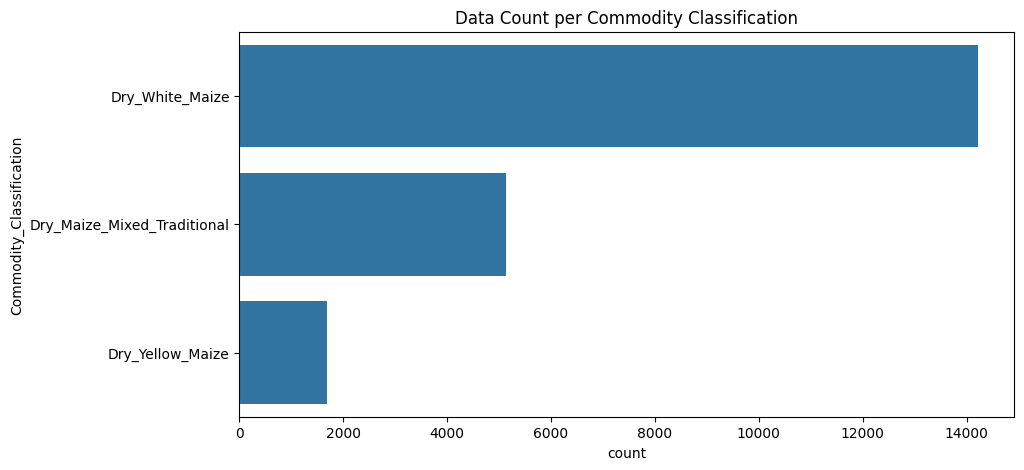

In [64]:
# Count plots
plt.figure(figsize=(10,5))
sns.countplot(y='County', data=df, order=df['County'].value_counts().index)
plt.title("Data Count per County")
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(y='Commodity_Classification', data=df)
plt.title("Data Count per Commodity Classification")
plt.show()

#### **Box Plor: After Transformation**

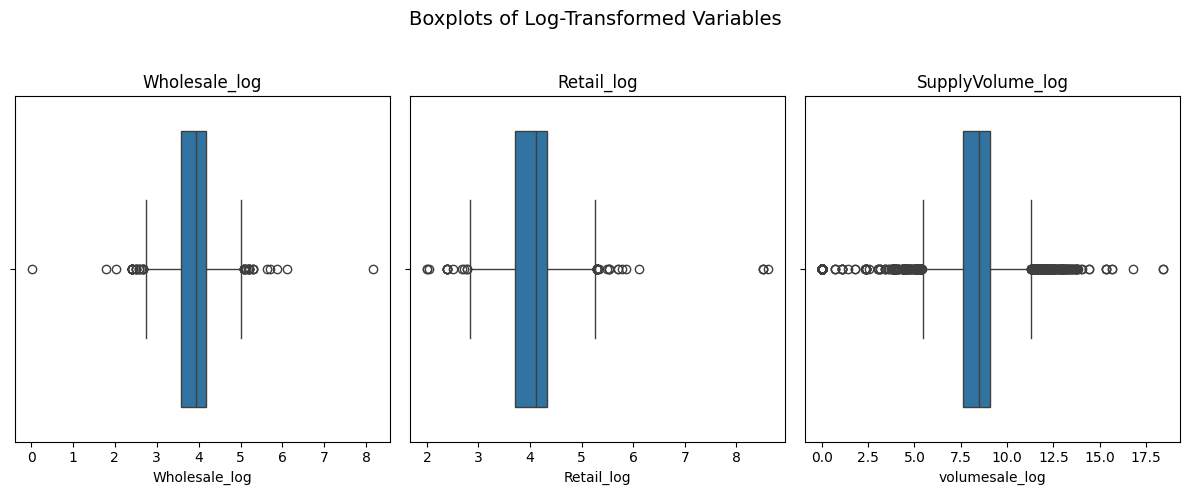

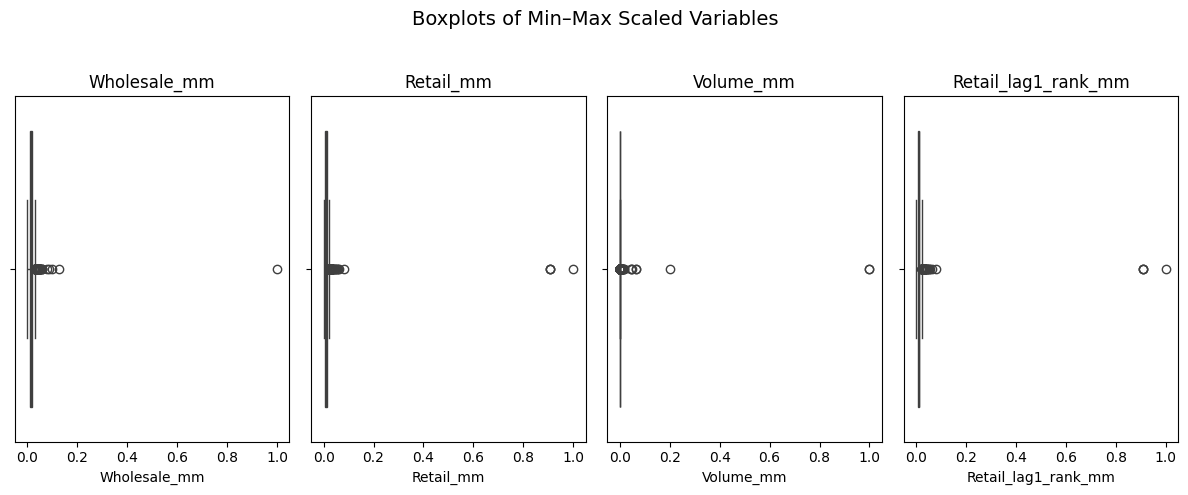

In [65]:
# 1️Log-transformed variables
plt.figure(figsize=(12,5))
plt.suptitle("Boxplots of Log-Transformed Variables", fontsize=14)

plt.subplot(1,3,1)
sns.boxplot(x='Wholesale_log', data=df2)
plt.title("Wholesale_log")

plt.subplot(1,3,2)
sns.boxplot(x='Retail_log', data=df2)
plt.title("Retail_log")

plt.subplot(1,3,3)
sns.boxplot(x='volumesale_log', data=df2)
plt.title("SupplyVolume_log")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Min–Max scaled variables
plt.figure(figsize=(12,5))
plt.suptitle("Boxplots of Min–Max Scaled Variables", fontsize=14)

plt.subplot(1,4,1)
sns.boxplot(x='Wholesale_mm', data=df2)
plt.title("Wholesale_mm")

plt.subplot(1,4,2)
sns.boxplot(x='Retail_mm', data=df2)
plt.title("Retail_mm")

plt.subplot(1,4,3)
sns.boxplot(x='Volume_mm', data=df2)
plt.title("Volume_mm")

plt.subplot(1,4,4)
sns.boxplot(x='Retail_lag1_rank_mm', data=df2)
plt.title("Retail_lag1_rank_mm")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [66]:
# --- Quantile calculations (just for reference, not removing rows) ---
# lower_wholesale = df['Wholesale'].quantile(0.1)
# upper_wholesale = df['Wholesale'].quantile(0.9)

# lower_retail = df['Retail'].quantile(0.1)
# upper_retail = df['Retail'].quantile(0.9)


- ##### **Correlation**

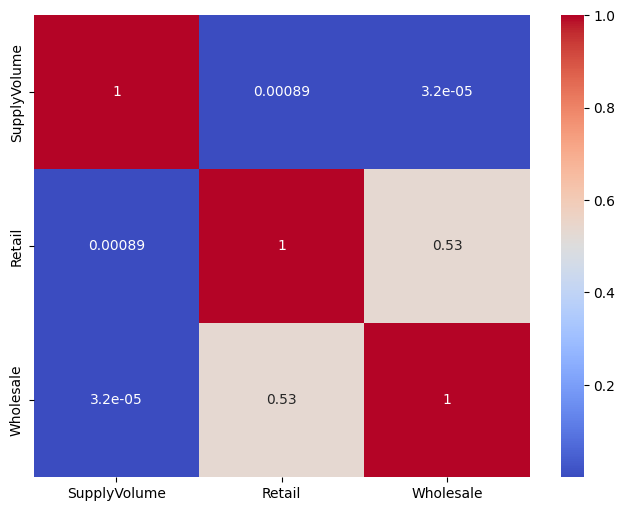

In [67]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['SupplyVolume', 'Retail', 'Wholesale']].corr(), annot=True, cmap='coolwarm')
plt.show()

In [68]:
df2.columns

Index(['Commodity_Classification', 'Commodity', 'Classification', 'County',
       'Market', 'Year', 'Month', 'Year_Month', 'WeekofYear', 'Year_Week',
       'SupplyVolume', 'Retail', 'Wholesale', 'Unit', 'Retail_lag1',
       'latitude', 'longitude', 'Wholesale_log', 'Retail_log',
       'Retail_lag1_log', 'volumesale_log', 'Wholesale_rank', 'Retail_rank',
       'Volume_rank', 'Retail_lag1_rank', 'Wholesale_mm', 'Retail_mm',
       'Volume_mm', 'Retail_lag1_rank_mm'],
      dtype='object')

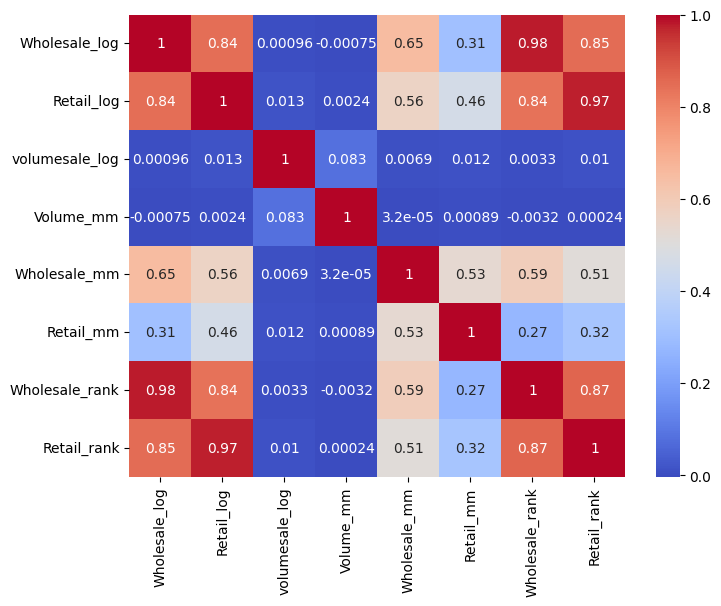

In [69]:
plt.figure(figsize=(8,6))
sns.heatmap(df2[['Wholesale_log',
                 'Retail_log', 
                 'volumesale_log',
                 'Volume_mm','Wholesale_mm','Retail_mm','Wholesale_rank','Retail_rank']].corr(), annot=True, cmap='coolwarm')
plt.show()


#### **Scatter Plot Retail vs Wholesale**

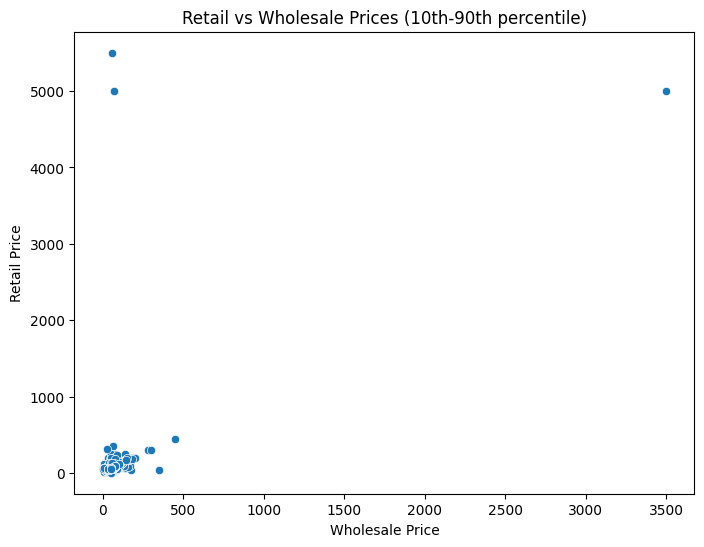

In [70]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Wholesale', y='Retail', data=df)
plt.title('Retail vs Wholesale Prices (10th-90th percentile)')
plt.xlabel('Wholesale Price')
plt.ylabel('Retail Price')
plt.show()

#### **Scatter Plot Retail_log vs Wholesale_log**

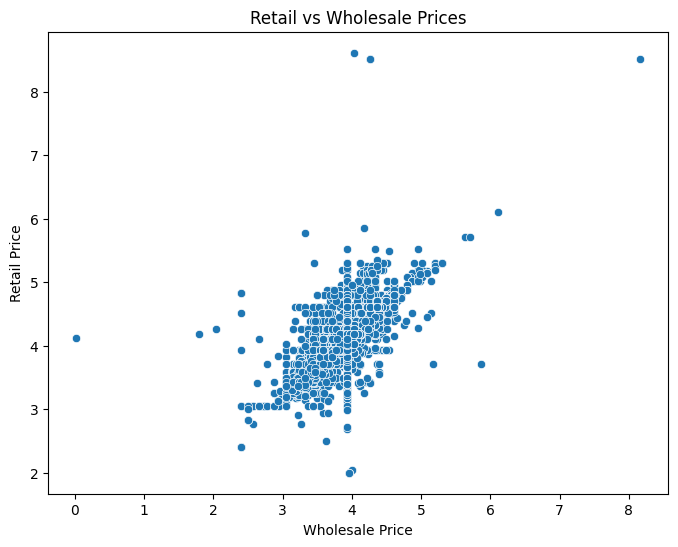

In [71]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Wholesale_log', y='Retail_log', data=df2)
plt.title('Retail vs Wholesale Prices')
plt.xlabel('Wholesale Price')
plt.ylabel('Retail Price')
plt.show()

#### **Scatter Plot Retail_log vs SupplyVolume_log**

# Apply log transformation (add small constant to avoid log(0))
df2['volumesale_log'] = np.log1p(df["SupplyVolume"])

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='volumesale_log', y='Retail_log', data=df)
plt.title('Log-Transformed Retail vs Volume Sale Prices')
plt.xlabel('Log(volumesale Price)')
plt.ylabel('Log(Retail Price)')
plt.show()

##### **Quantile Transformation / Rank-Based Scaling**

In [72]:
qt = QuantileTransformer(output_distribution='normal')
df[['Wholesale_qt', 'Retail_qt']] = qt.fit_transform(df[['Wholesale', 'Retail']])

plt.figure(figsize=(8,6))
sns.scatterplot(x='Wholesale_qt', y='Retail_qt', data=df)
plt.title('Quantile Transformed Retail vs Wholesale Prices')
plt.show()

NameError: name 'QuantileTransformer' is not defined

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Wholesale', y='Retail', data=df)
plt.title('Retail vs Wholesale Prices')
plt.xlabel('Wholesale Price')
plt.ylabel('Retail Price')
plt.show()

#### **Encoding Strategies**

#### **Linear Regression**

### **Linear Regression with Time Series**

- ##### **Time Series Insights**

- **Monthly**

In [ ]:
# Monthly SupplyVolume trend
monthly = df.groupby('Year_Month')['SupplyVolume'].sum().reset_index()
monthly['Year_Month'] = pd.to_datetime(monthly['Year_Month'])
plt.figure(figsize=(12,6))
sns.lineplot(x='Year_Month', y='SupplyVolume', data=monthly)
plt.title("Monthly Supply Volume Trend")
plt.show()

In [ ]:
# Monthly SupplyVolume trend
monthly = df.groupby('Year_Month')['Retail_log'].sum().reset_index()
monthly['Year_Month'] = pd.to_datetime(monthly['Year_Month'])
plt.figure(figsize=(12,6))
sns.lineplot(x='Year_Month', y='Retail_log', data=monthly)
plt.title("Monthly Supply Volume Trend")
plt.show()


- **Daily**

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Retail', data=df)
plt.title("Daily Retail Trend")
plt.show()

- **Dailly Transformed**

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Retail_log', data=df)
plt.title("Daily Retail Trend")
plt.show()

##### **Split**

In [ ]:
# Define target
target = "Retail"
y = df[target]

# Define feature (lagged Retail)
X = df[["Retail_lag1"]]


In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
print(y.head())
print(X.head())

In [ ]:
cutoff = int(len(X)*0.8)
X_train, y_train = X.iloc[:cutoff],y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:],y.iloc[cutoff:]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#### **Model**

- ##### **Base Line Model**

In [ ]:
# Baseline prediction: mean of y_train
y_pred_baseline = [y_train.mean()] * len(y_train)

# Compute MAE
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

# Print results
print("Mean Retail Reading (Train):", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))


- #### **Itration**

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

In [ ]:
y_pred_train = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)
y_pred_test[:5]

- #### **Evaluation**

In [ ]:
training_mae=mean_absolute_error(y_train,y_pred_train)
test_mae=mean_absolute_error(y_test,y_pred_test)
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))


- #### **Communication**

In [ ]:
# Extract intercept and coefficient
intercept = model_lr.intercept_
coefficient = model_lr.coef_[0]  # only one feature

# Print regression equation
print(f"P2 = {intercept:.2f} + ({coefficient:.2f} * P2.L1)")


#### **Random Forest**

#### **Split**

In [ ]:

X = df[["Commodity_Classification_encoded","County_encoded","Market_encoded","volumesale_log"]]
y = df["Retail_log"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


##### **Random Forest Model**

In [ ]:
model = RandomForestRegressor(n_estimators=300)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("R²:", r2_score(y_test, pred))


### **Feature Importance**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances from your model
importances = model.feature_importances_
feature_names = X.columns

# Put into a DataFrame for easier handling
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(fi_df["Feature"], fi_df["Importance"])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance for Maize Price Prediction Model")
plt.gca().invert_yaxis()
plt.show()


#####  **xgboost**

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X_train, y_train)
pred = model.predict(X_test)


In [ ]:
print("MAE:", mean_absolute_error(y_test, pred))
print("R²:", r2_score(y_test, pred))


In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model, max_num_features=15, importance_type='gain')
plt.show()
